In [4]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms, datasets
from torchvision.utils import save_image
from torch.utils.data.dataset import Dataset
from PIL import Image
import random
from torch.utils.data.sampler import SequentialSampler

os.environ["CUDA_VISIBLE_DEVICES"]='3,4'


## Training

In [29]:
class AvenueDataset(Dataset):
    def __init__(self, root, transforms=None):
        self.root=root
        self.transforms=transforms
        self.videonames=(os.listdir(self.root))
        self.videonames.sort()
        
    def __getitem__(self, index):
        transform = transforms.Compose([
                                        transforms.Grayscale(),
                                        transforms.Resize([227,227]),
                                        transforms.ToTensor(),
                                        transforms.Normalize((0.5,),(0.5,))
                                        ])
        if index % 66 == 0:
            self.randperm=torch.randperm(66)
        video_name=self.videonames[self.randperm[index % 66]]
        video_dir=os.path.join(self.root, video_name)
        num_frame=len(os.listdir(video_dir))
        start_index=random.randint(0, num_frame-10)
        image_list = os.listdir(video_dir)
        image_list.sort()
        input_tensor = [torch.squeeze(transform(Image.open(os.path.join(video_dir, image_list[i])))) for i in range(start_index, start_index+10)]
        #image_path=os.path.join(video_dir, 'image-%05d.jpg')
        #input_tensor = [torch.squeeze(transform(Image.open(image_path % i))) for i in range(start_index, start_index+10)]
        input_tensor = torch.stack(input_tensor)
        return input_tensor, video_name
            
        
    def __len__(self): # 가능한 모든 tensor(10x227x227)의 수
        return sum([len(os.listdir(os.path.join(self.root, subdir))) for subdir in os.listdir(self.root)]) - 9*len(os.listdir(self.root))

In [30]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

sample_dir = 'samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)
checkpoint_dir = 'checkpoints'
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)
num_epochs = 5
batch_size = 32
learning_rate = 0.001

traindir = 'data'

train_dataset = AvenueDataset(traindir)

sampler=SequentialSampler(train_dataset)

data_loader = torch.utils.data.DataLoader(dataset=train_dataset,batch_size=batch_size,shuffle=False, sampler=sampler)


In [4]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(15,6))

for _, (d, l) in enumerate(data_loader):
    for i in range(10):
        a=fig.add_subplot(2,5,i+1)
        a.set_title('frame %d'%(i+1))
        plt.imshow(d[0][i])
    break
plt.show()

<Figure size 1500x600 with 10 Axes>

In [143]:



class CAE(nn.Module):
    def __init__(self):
        super(CAE, self).__init__()
        self.cv1 = nn.Conv2d(10,512,11,4)
        self.pl1 = nn.MaxPool2d(2,return_indices=True)
        self.cv2 = nn.Conv2d(512,256,5, padding=2)
        self.pl2 = nn.MaxPool2d(2,return_indices=True)
        self.cv3 = nn.Conv2d(256,128,3, padding=1)
        self.dc1 = nn.ConvTranspose2d(128,256,3,padding=1)
        self.up1 = nn.MaxUnpool2d(2)
        self.dc2 = nn.ConvTranspose2d(256,512,3,padding=1)
        self.up2 = nn.MaxUnpool2d(2)
        self.dc3 = nn.ConvTranspose2d(512,1024,5,padding=2)
        self.dc4 = nn.ConvTranspose2d(1024,10,11,4)
        
        torch.nn.init.xavier_uniform_(self.cv1.weight)
        torch.nn.init.xavier_uniform_(self.cv2.weight)
        torch.nn.init.xavier_uniform_(self.cv3.weight)
        torch.nn.init.xavier_uniform_(self.dc1.weight)
        torch.nn.init.xavier_uniform_(self.dc2.weight)
        torch.nn.init.xavier_uniform_(self.dc3.weight)
        torch.nn.init.xavier_uniform_(self.dc4.weight)
        
        
    def encode(self, x):
        x = F.relu(self.cv1(x))
        self.size1=x.size()
        x, self.idx1 = self.pl1(x)
        x = F.relu(self.cv2(x))
        self.size2=x.size()
        x, self.idx2 = self.pl1(x)
        x = F.relu(self.cv3(x))
        return x
    
    def decode(self, x):
        x = F.relu(self.dc1(x))
        x = self.up1(x,self.idx2,output_size=self.size2)
        x = F.relu(self.dc2(x))
        x = self.up2(x,self.idx1,output_size=self.size1)
        x = F.relu(self.dc3(x))
        x = torch.tanh(self.dc4(x))
        return x
    
    def forward(self, x):
        out = self.encode(x)
        out = self.decode(out)
        return out
    

In [32]:

model = CAE().to(device)
optimizer = torch.optim.Adagrad(model.parameters(), lr=learning_rate)
criteria = nn.MSELoss()


In [7]:


for epoch in range(num_epochs):
    for i, (x, _) in enumerate(data_loader):
        x = x.to(device)
        x_reconst = model(x)
        
        reconst_loss = criteria(x_reconst, x)
    
        optimizer.zero_grad()
        reconst_loss.backward()
        optimizer.step()
        
        if(i+1)%10==0:
            print("Epoch[{}/{}], Step[{}/{}], Reconst Loss: {:.4f}"
                  .format(epoch+1, num_epochs, i+1, len(data_loader), reconst_loss.item()))
    with torch.no_grad():
        # Save the sampled images
        denorm = x[0]*0.5+0.5
        denorm_reconst = x_reconst[0]*0.5+0.5
        save_image(denorm.view(-1,1,227,227),os.path.join(sample_dir, 'sampled-{:03d}.png'.format(epoch+1)))
        
        # Save the reconstructed images
        x_concat = torch.cat([denorm.view(-1,1,227,227),denorm_reconst.view(-1,1,227,227)], dim = 3)
        save_image(x_concat, os.path.join(sample_dir, 'reconst-{:03d}.png'.format(epoch+1)))
        
        # Save the model parameters
        torch.save(model.state_dict(), (os.path.join(checkpoint_dir, 'checkpoint-{:03d}.pth'.format(epoch+1))))

Epoch[1/5], Step[10/753], Reconst Loss: 0.2106
Epoch[1/5], Step[20/753], Reconst Loss: 0.1016
Epoch[1/5], Step[30/753], Reconst Loss: 0.0510
Epoch[1/5], Step[40/753], Reconst Loss: 0.0398
Epoch[1/5], Step[50/753], Reconst Loss: 0.0443
Epoch[1/5], Step[60/753], Reconst Loss: 0.0297
Epoch[1/5], Step[70/753], Reconst Loss: 0.0257
Epoch[1/5], Step[80/753], Reconst Loss: 0.0249
Epoch[1/5], Step[90/753], Reconst Loss: 0.0219
Epoch[1/5], Step[100/753], Reconst Loss: 0.0175
Epoch[1/5], Step[110/753], Reconst Loss: 0.0178
Epoch[1/5], Step[120/753], Reconst Loss: 0.0146
Epoch[1/5], Step[130/753], Reconst Loss: 0.0140
Epoch[1/5], Step[140/753], Reconst Loss: 0.0129
Epoch[1/5], Step[150/753], Reconst Loss: 0.0129
Epoch[1/5], Step[160/753], Reconst Loss: 0.0117
Epoch[1/5], Step[170/753], Reconst Loss: 0.0104
Epoch[1/5], Step[180/753], Reconst Loss: 0.0110
Epoch[1/5], Step[190/753], Reconst Loss: 0.0124
Epoch[1/5], Step[200/753], Reconst Loss: 0.0130
Epoch[1/5], Step[210/753], Reconst Loss: 0.0092
E

Epoch[3/5], Step[230/753], Reconst Loss: 0.0041
Epoch[3/5], Step[240/753], Reconst Loss: 0.0036
Epoch[3/5], Step[250/753], Reconst Loss: 0.0041
Epoch[3/5], Step[260/753], Reconst Loss: 0.0039
Epoch[3/5], Step[270/753], Reconst Loss: 0.0037
Epoch[3/5], Step[280/753], Reconst Loss: 0.0032
Epoch[3/5], Step[290/753], Reconst Loss: 0.0045
Epoch[3/5], Step[300/753], Reconst Loss: 0.0039
Epoch[3/5], Step[310/753], Reconst Loss: 0.0040
Epoch[3/5], Step[320/753], Reconst Loss: 0.0036
Epoch[3/5], Step[330/753], Reconst Loss: 0.0038
Epoch[3/5], Step[340/753], Reconst Loss: 0.0049
Epoch[3/5], Step[350/753], Reconst Loss: 0.0036
Epoch[3/5], Step[360/753], Reconst Loss: 0.0038
Epoch[3/5], Step[370/753], Reconst Loss: 0.0041
Epoch[3/5], Step[380/753], Reconst Loss: 0.0037
Epoch[3/5], Step[390/753], Reconst Loss: 0.0042
Epoch[3/5], Step[400/753], Reconst Loss: 0.0033
Epoch[3/5], Step[410/753], Reconst Loss: 0.0039
Epoch[3/5], Step[420/753], Reconst Loss: 0.0036
Epoch[3/5], Step[430/753], Reconst Loss:

Epoch[5/5], Step[450/753], Reconst Loss: 0.0036
Epoch[5/5], Step[460/753], Reconst Loss: 0.0030
Epoch[5/5], Step[470/753], Reconst Loss: 0.0030
Epoch[5/5], Step[480/753], Reconst Loss: 0.0031
Epoch[5/5], Step[490/753], Reconst Loss: 0.0032
Epoch[5/5], Step[500/753], Reconst Loss: 0.0037
Epoch[5/5], Step[510/753], Reconst Loss: 0.0030
Epoch[5/5], Step[520/753], Reconst Loss: 0.0030
Epoch[5/5], Step[530/753], Reconst Loss: 0.0027
Epoch[5/5], Step[540/753], Reconst Loss: 0.0028
Epoch[5/5], Step[550/753], Reconst Loss: 0.0033
Epoch[5/5], Step[560/753], Reconst Loss: 0.0034
Epoch[5/5], Step[570/753], Reconst Loss: 0.0029
Epoch[5/5], Step[580/753], Reconst Loss: 0.0031
Epoch[5/5], Step[590/753], Reconst Loss: 0.0031
Epoch[5/5], Step[600/753], Reconst Loss: 0.0033
Epoch[5/5], Step[610/753], Reconst Loss: 0.0033
Epoch[5/5], Step[620/753], Reconst Loss: 0.0032
Epoch[5/5], Step[630/753], Reconst Loss: 0.0033
Epoch[5/5], Step[640/753], Reconst Loss: 0.0032
Epoch[5/5], Step[650/753], Reconst Loss:

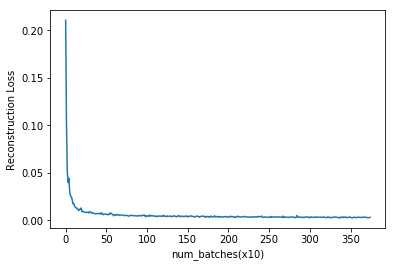

In [25]:
import matplotlib.pyplot as plt

losses = []
with open('loss.txt','r') as f:
    for line in f:
        losses.append(float(line.split(':')[1]))

plt.plot(losses)
plt.ylabel('Reconstruction Loss')
plt.xlabel('num_batches(x10)')
plt.show()


## Testing

In [33]:
from torch.utils.data.dataset import Dataset
import torch
class AvenueTestDataset(Dataset):
    def __init__(self, root, video_index, transforms=None):
        self.root=root
        self.video_index=video_index
        self.videos = os.listdir(self.root)
        self.videos.sort()
    def __getitem__(self, index):
        transform = transforms.Compose([
                                        transforms.Grayscale(),
                                        transforms.Resize([227,227]),
                                        transforms.ToTensor(),
                                        transforms.Normalize((0.5,),(0.5,))
                                        ])

        video_dir=os.path.join(self.root, self.videos[self.video_index])
        num_frame=len(os.listdir(video_dir))
        image_list = os.listdir(video_dir)
        image_list.sort()
        input_tensor = [torch.squeeze(transform(Image.open(os.path.join(video_dir, image_list[i])))) for i in range(index, index+10)]
        input_tensor = torch.stack(input_tensor)
        return input_tensor
    
    def __len__(self):
        video_dir=os.path.join(self.root, self.videos[self.video_index])
        return len(os.listdir(video_dir))-9

In [34]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CAE().to(device)
model.load_state_dict(torch.load('checkpoints/checkpoint-005.pth'))
test_dataset = AvenueTestDataset('test_data/',0)
criteria = nn.MSELoss()


In [33]:
losses = []
for i in range(len(test_dataset)):
    with torch.no_grad():
        x = test_dataset[i]
        x = x.to(device)
        x.unsqueeze_(0)
        x_reconst = model(x)
        loss = criteria(x_reconst,x)
        losses.append(loss.item())
        print('loss: %f' % loss)

loss: 0.004609
loss: 0.004397
loss: 0.004391
loss: 0.004378
loss: 0.004436
loss: 0.004271
loss: 0.004412
loss: 0.004310
loss: 0.004360
loss: 0.004290
loss: 0.004227
loss: 0.004300
loss: 0.004383
loss: 0.004336
loss: 0.004429
loss: 0.004461
loss: 0.004439
loss: 0.004416
loss: 0.004383
loss: 0.004360
loss: 0.004338
loss: 0.004281
loss: 0.004342
loss: 0.004304
loss: 0.004322
loss: 0.004331
loss: 0.004388
loss: 0.004471
loss: 0.004447
loss: 0.004368
loss: 0.004467
loss: 0.004472
loss: 0.004472
loss: 0.004409
loss: 0.004438
loss: 0.004405
loss: 0.004390
loss: 0.004351
loss: 0.004381
loss: 0.004368
loss: 0.004392
loss: 0.004367
loss: 0.004354
loss: 0.004416
loss: 0.004344
loss: 0.004402
loss: 0.004479
loss: 0.004489
loss: 0.004448
loss: 0.004446
loss: 0.004505
loss: 0.004501
loss: 0.004446
loss: 0.004441
loss: 0.004514
loss: 0.004476
loss: 0.004516
loss: 0.004579
loss: 0.004609
loss: 0.004621
loss: 0.004611
loss: 0.004504
loss: 0.004499
loss: 0.004505
loss: 0.004442
loss: 0.004474
loss: 0.00

loss: 0.006442
loss: 0.006433
loss: 0.006310
loss: 0.006299
loss: 0.006326
loss: 0.006286
loss: 0.006131
loss: 0.006028
loss: 0.005880
loss: 0.005950
loss: 0.005884
loss: 0.005878
loss: 0.005827
loss: 0.005893
loss: 0.005896
loss: 0.005906
loss: 0.005961
loss: 0.006025
loss: 0.005953
loss: 0.005979
loss: 0.006075
loss: 0.005997
loss: 0.005941
loss: 0.006004
loss: 0.005803
loss: 0.005772
loss: 0.005827
loss: 0.005868
loss: 0.005968
loss: 0.006015
loss: 0.006013
loss: 0.005979
loss: 0.005893
loss: 0.005781
loss: 0.005889
loss: 0.005866
loss: 0.005846
loss: 0.005744
loss: 0.005854
loss: 0.005834
loss: 0.005846
loss: 0.005747
loss: 0.005746
loss: 0.005794
loss: 0.005885
loss: 0.006033
loss: 0.006044
loss: 0.006152
loss: 0.006252
loss: 0.006449
loss: 0.006428
loss: 0.006353
loss: 0.006366
loss: 0.006382
loss: 0.006426
loss: 0.006524
loss: 0.006608
loss: 0.006603
loss: 0.006605
loss: 0.006535
loss: 0.006442
loss: 0.006273
loss: 0.006212
loss: 0.006120
loss: 0.005965
loss: 0.005861
loss: 0.00

loss: 0.008277
loss: 0.008199
loss: 0.008257
loss: 0.008052
loss: 0.007957
loss: 0.007904
loss: 0.007902
loss: 0.007823
loss: 0.007854
loss: 0.007969
loss: 0.007955
loss: 0.007901
loss: 0.008023
loss: 0.008159
loss: 0.008080
loss: 0.008104
loss: 0.008011
loss: 0.007954
loss: 0.007658
loss: 0.007760
loss: 0.007762
loss: 0.007658
loss: 0.007597
loss: 0.007602
loss: 0.007592
loss: 0.007602
loss: 0.007604
loss: 0.007519
loss: 0.007534
loss: 0.007472
loss: 0.007449
loss: 0.007454
loss: 0.007473
loss: 0.007546
loss: 0.007630
loss: 0.007597
loss: 0.007440
loss: 0.007496
loss: 0.007654
loss: 0.007665
loss: 0.007691
loss: 0.007578
loss: 0.007575
loss: 0.007610
loss: 0.007669
loss: 0.007677
loss: 0.007788
loss: 0.007752
loss: 0.007551
loss: 0.007474
loss: 0.007553
loss: 0.007411
loss: 0.007263
loss: 0.007265
loss: 0.007192
loss: 0.007080
loss: 0.006967
loss: 0.006889
loss: 0.006930
loss: 0.006902
loss: 0.006923
loss: 0.006887
loss: 0.006730
loss: 0.006664
loss: 0.006747
loss: 0.006635
loss: 0.00

In [34]:
max_loss = max(losses)
min_loss = min(losses)
regularity_list = [1 - (loss - min_loss) / max_loss for loss in losses]

## Anomaly Detection

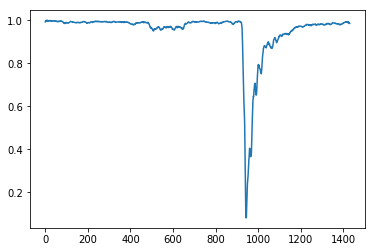

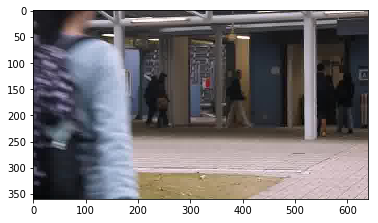

In [35]:
import matplotlib.pyplot as plt
plt.plot(regularity_list)
plt.show()
plt.imshow(Image.open('test_data/Avenue_testing_01/image-00945.jpg'))

In [36]:
regularity_list.index(min(regularity_list))

943

## Preparing files for performance measure

In [159]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CAE().to(device)
model.load_state_dict(torch.load('checkpoints/checkpoint-005.pth'))
criteria = nn.MSELoss()

In [160]:
for i in range(0,69):
    test_dataset = AvenueTestDataset('test_data/',i)
    with open('testing_optical_regularity_list/'+'%d_reg.txt'%i, 'w') as f:
        losses = []
        for i in range(len(test_dataset)):
            with torch.no_grad():
                x = test_dataset[i]
                x = x.to(device)
                x.unsqueeze_(0)
                x_reconst = model(x)
                loss = criteria(x_reconst,x)
                losses.append(loss.item())
                print('loss: %f' % loss)
        max_loss = max(losses)
        min_loss = min(losses)
        regularity_list = [1 - (loss - min_loss) / max_loss for loss in losses]
        for j in range(len(regularity_list)):
            f.write('%f\n'%regularity_list[j])

FileNotFoundError: [Errno 2] No such file or directory: 'test_data/Avenue_testing_01/flow_x_00001.jpg'

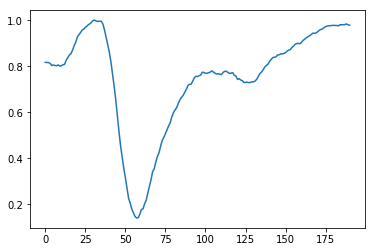

57


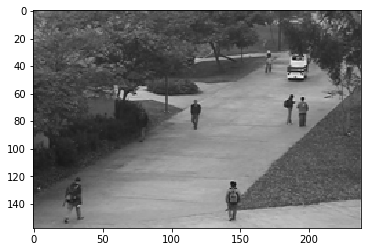

In [39]:
regularity_list = []
with open('testing_regularity_list/40_reg.txt') as f:
    for line in f:
        regularity_list.append(float(line))
import matplotlib.pyplot as plt
plt.plot(regularity_list)
plt.show()

print(regularity_list.index(min(regularity_list)))
plt.imshow(Image.open('test_data/UCSDped1_testing_020/154.tif'))

torch.Size([1, 10, 227, 227])
tensor([[0.3490, 0.3490, 0.3451,  ..., 0.2431, 0.2627, 0.2627],
        [0.3294, 0.3294, 0.3255,  ..., 0.2510, 0.2745, 0.2784],
        [0.3059, 0.3059, 0.3020,  ..., 0.2588, 0.2902, 0.2941],
        ...,
        [0.4784, 0.4784, 0.4784,  ..., 0.7020, 0.7294, 0.7333],
        [0.4824, 0.4824, 0.4824,  ..., 0.7059, 0.7333, 0.7373],
        [0.4824, 0.4824, 0.4824,  ..., 0.7098, 0.7373, 0.7412]])
tensor([[0.4471, 0.4471, 0.4471,  ..., 0.6157, 0.6235, 0.6235],
        [0.4196, 0.4196, 0.4196,  ..., 0.5569, 0.5608, 0.5608],
        [0.3843, 0.3843, 0.3843,  ..., 0.4784, 0.4784, 0.4784],
        ...,
        [0.4667, 0.4667, 0.4745,  ..., 0.6863, 0.6902, 0.6902],
        [0.4549, 0.4549, 0.4588,  ..., 0.6627, 0.6627, 0.6627],
        [0.4431, 0.4431, 0.4431,  ..., 0.6471, 0.6431, 0.6431]])


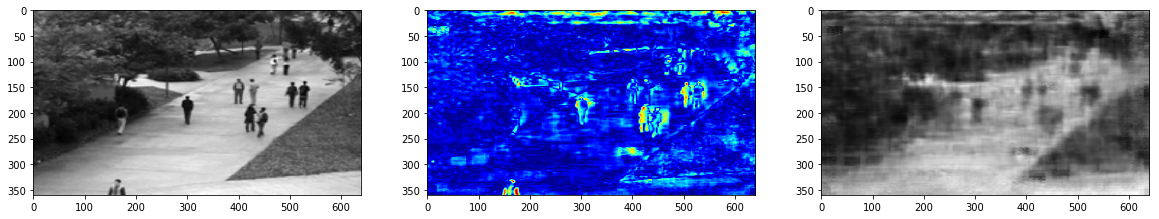

In [65]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CAE().to(device)
model.load_state_dict(torch.load('Avenue_checkpoints/checkpoint-004.pth'))
test_dataset = AvenueTestDataset('test_data/',56)
criteria = nn.MSELoss()

import matplotlib.pyplot as plt

inverse_transform = transforms.Compose([transforms.Normalize((0.0,),(1/0.5,)),
                                        transforms.Normalize((-0.5,),(1,)),
                                        transforms.ToPILImage(),
                                        transforms.Resize((360,640)),transforms.ToTensor()])
fig = plt.figure(figsize=(20,10));
with torch.no_grad():
    x = test_dataset[0]
    x = x.to(device)
    x = x.unsqueeze_(0)
    x_reconst = model(x)
diff = x.squeeze(0)[0]-x_reconst.squeeze(0)[0]
diff = torch.abs(diff)
diff = (diff-torch.min(diff))/torch.max(diff)
x = x.squeeze(0)[0].unsqueeze(0).to(torch.device('cpu'))
x = inverse_transform(x)
x = x.squeeze(0)
diff = diff.unsqueeze(0).to(torch.device('cpu'))
diff = inverse_transform(diff)
diff = diff.squeeze(0)
fig.add_subplot(1,3,1)
plt.imshow(x,cmap='gray')
fig.add_subplot(1,3,2)
plt.imshow(diff, cmap='jet')
fig.add_subplot(1,3,3)
print(x_reconst.size())
x_reconst = x_reconst.squeeze(0)[0].unsqueeze(0).to(torch.device('cpu'))
x_reconst = inverse_transform(x_reconst)
x_reconst = x_reconst.squeeze(0)
plt.imshow(x_reconst, cmap='gray')

print(x)
print(x_reconst)

In [27]:
model = CAE().to(device)
model.load_state_dict(torch.load('Avenue_checkpoints/checkpoint-005.pth'))
for param in model.parameters():
    print(param.data)

NameError: name 'CAE' is not defined

In [192]:
transform = transforms.Compose([
                                        transforms.Grayscale(),
                                        transforms.Resize([227,227]),
                                        transforms.ToTensor(),
                                        transforms.Normalize((0.5,),(0.5,))
                                        ])
tensor1=  transform(Image.open('data/Avenue_training_1/image-00001.jpg'))
print(torch.min(tensor1), torch.max(tensor1))
tensor2= transform(Image.open('data/UCSDped1_training_001/001.tif'))
print(torch.min(tensor2), torch.max(tensor2))


tensor(-0.9294) tensor(0.9765)
tensor(-0.9608) tensor(0.7569)


## Performance Measure (Correct Detection/False Alarm, AUC/EER)

In [12]:
#Combining all regularity lists of test videos
regularity_list = []
for i in range(0,69):
    if i>=21 and i<=56:
        continue
    with open('testing_optical_regularity_list/%d_reg.txt'%i) as f:
        for line in f:
            regularity_list.append(float(line))
    
print(len(regularity_list))
print(15324-9*21)

17169
15135


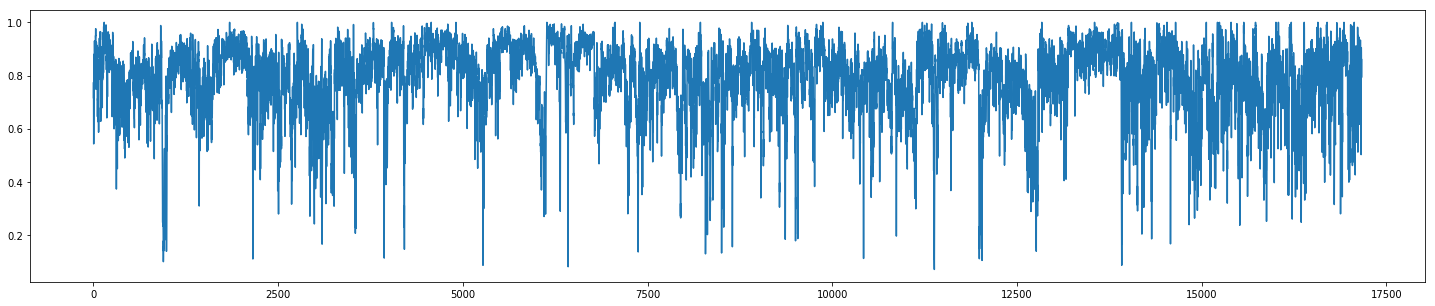

In [240]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(25,5))
ax = fig.add_subplot(111)
ax.plot(regularity_list)

plt.show()

Avenue_testing_01 946
Avenue_testing_02 1075
Avenue_testing_03 625
Avenue_testing_04 390
Avenue_testing_04 663
Avenue_testing_05 789


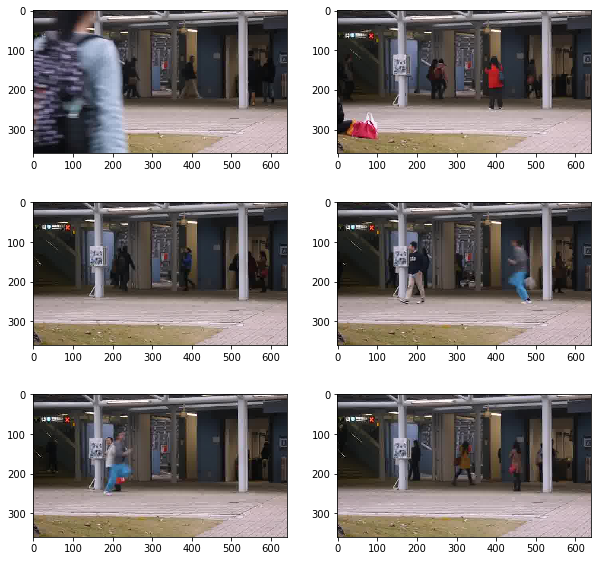

In [219]:
import matplotlib.pyplot as plt
from PIL import Image
import os
lists_path = 'testing_regularity_list/'
data_path = 'test_data/'
def file_len(fname):
    with open(fname) as f:
        for i, l in enumerate(f):
            pass
    return i + 1

def frame_index(index):
    len_list = []
    for i in range(0,69):
        len_list.append(file_len(os.path.join(lists_path, '%d_reg.txt'%i)))
    acum=0
    for i in range(0,69):
        if(acum+len_list[i] > index):
            break
        acum = acum+len_list[i]
    return i, index-acum

video_list = os.listdir(data_path)
video_list.sort()
fig=plt.figure(figsize=(10,10))
anomaly_range_list=[(900,1000),(2400,2600),(3100,3400),(3700,4000),(4000,4300),(5000,5300)]
for i in range(len(anomaly_range_list)):
    values = regularity_list[anomaly_range_list[i][0]:anomaly_range_list[i][1]]
    video_index, frame = frame_index(anomaly_range_list[i][0]+values.index(min(values)))
    print(video_list[video_index], frame)
    fig.add_subplot(3,2,i+1)
    frame_list=os.listdir(os.path.join(data_path, video_list[video_index]))
    frame_list.sort()
    plt.imshow(Image.open(os.path.join(data_path, video_list[video_index], frame_list[frame])))


In [220]:
import os
from scipy import misc
path = 'your_file_path'
for i in range(1,13):
    for j in range(len(os.listdir('../UCSD_Anomaly_Dataset.v1p2/UCSDped2/Test/Test%03d_gt/'%i))):
        image= misc.imread('../UCSD_Anomaly_Dataset.v1p2/UCSDped2/Test/Test001_gt/%03d.bmp'%(j+1), flatten= 0)
        print(image.max()==1)

/home/visitor/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  


False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Fals

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Fals

In [238]:
##Combining all label lists of test videos
import scipy.io
import numpy as np
import os
from scipy import misc
label_list = []
n = 0
for i in range(1,22):
    mat = scipy.io.loadmat('testing_label_mask/%d_label.mat'%i)
    label = mat.get('volLabel')
    for j in range(len(label[0])-5):#9 or 5
        if label[0][j].sum(axis=0).sum(axis=0) > 0:
            label_list.append(1)
        else:
            label_list.append(0)
for i in range(1,13):
    path = '../UCSD_Anomaly_Dataset.v1p2/UCSDped2/Test/Test%03d_gt/'%i
    for j in range(len(os.listdir(path))-5):#9 or 5
        image_list = os.listdir(path)
        image_list.sort()
        image= misc.imread(os.path.join(path, image_list[j]), flatten= 0)
        if(image.max()==0):
            label_list.append(0)
        else:
            label_list.append(1)

len(label_list)

/home/visitor/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:21: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


17169

In [241]:
def get_anomaly_list(regularity_list, threshold):
    l = [i for i in range(len(regularity_list)) if regularity_list[i] < threshold]
    if(l==[]):
        return []
    num_detection = 0
    prev_start = l[0]
    detected = []
    for i in range(len(l)-1):
        if (l[i+1]-l[i]>50):
            detected.append((prev_start, l[i]))
            prev_start = l[i+1]
    detected.append((prev_start, l[len(l)-1]))
    return detected


In [247]:
def get_correct_list(anomaly_list, label_list):
    correct_list = []
    num_labels = 0
    for anomaly in anomaly_list:
        for i in range(anomaly[0], anomaly[1]+1):
            if label_list[i]:
                num_labels = num_labels + 1
        if num_labels / (anomaly[1]-anomaly[0]+1) > 0.5:
            correct_list.append(True)
        else:
            correct_list.append(False)
    return correct_list

In [248]:
def get_positive_rate(regularity_list, label_list, threshold):
    anomaly_list = get_anomaly_list(regularity_list, threshold)
    p = sum([e-s+1 for s,e in anomaly_list])
    tp_fn = label_list.count(1)
    tp = 0
    for anomaly in anomaly_list:
        for i in range(anomaly[0], anomaly[1]+1):
            if label_list[i]:
                tp = tp+1
    fp_tn = len(regularity_list)-tp_fn
    fp = p - tp

    
    tpr = tp / tp_fn
    fpr =fp / fp_tn
    return tpr, fpr

In [249]:
anomaly_list = get_anomaly_list(regularity_list, 0.8)
correct_list = get_correct_list(anomaly_list, label_list)
correct_detection = correct_list.count(True)
false_alarm = correct_list.count(False)
print('Correct Detection: ', correct_detection)
print('False Alarm: ', false_alarm)

Correct Detection:  20
False Alarm:  3


In [250]:
x = []
y = []
for i in range(100):
    tp, fp = get_positive_rate(regularity_list, label_list, 0.01*i)
    x.append(fp)
    y.append(tp)
eer_x = [0,1]
eer_y = [1,0]


AUC: 0.7115395657389172
EER: 0.35441547518923466


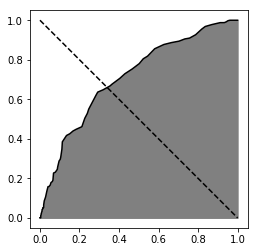

In [251]:
import matplotlib.pyplot as plt
from sklearn import metrics


fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(x, y, color='black')
ax.plot(x, [1-i for i in x], '--',color='black')
ax.set_aspect(1)
ax.fill_between(x,y, color='gray')
print('AUC:', metrics.auc(x,y))
fpr = x
tpr = y
fnr = [1-i for i in tpr]
eer = fpr[np.nanargmin(np.absolute((np.subtract(fnr, fpr))))]
print('EER:', eer)

## Spatial Localization of Regularity

In [ ]:
import matplotlib.pyplot as plt

inverse_transform = transforms.Compose([transforms.Normalize((0.0,),(1/0.5,)),
                                        transforms.Normalize((-0.5,),(1,)),
                                        transforms.ToPILImage(),
                                        transforms.Resize((360,640)),transforms.ToTensor()])
fig = plt.figure(figsize=(20,10));
model.load_state_dict(torch.load('Avenue_checkpoints/checkpoint-004.pth'))

test_dataset = AvenueTestDataset('test_data/',0)
with torch.no_grad():
    x = test_dataset[944]
    x = x.to(device)
    x = x.unsqueeze_(0)
    x_reconst = model(x)
diff = x.squeeze(0)[0]-x_reconst.squeeze(0)[0]
diff = torch.abs(diff)
diff = (diff-torch.min(diff))/torch.max(diff)
x = x.squeeze(0)[0].unsqueeze(0).to(torch.device('cpu'))
x = inverse_transform(x)
x = x.squeeze(0)
diff = diff.unsqueeze(0).to(torch.device('cpu'))
diff = inverse_transform(diff)
diff = diff.squeeze(0)
fig.add_subplot(1,3,1)
plt.imshow(x,cmap='gray')
fig.add_subplot(1,3,2)
plt.imshow(diff, cmap='jet')
fig.add_subplot(1,3,3)
print(x_reconst.size())
x_reconst = x_reconst.squeeze(0)[0].unsqueeze(0).to(torch.device('cpu'))
x_reconst = inverse_transform(x_reconst)
x_reconst = x_reconst.squeeze(0)
plt.imshow(x_reconst, cmap='gray')


## Optical Flow

In [6]:
class AvenueDataset(Dataset):
    def __init__(self, root, transforms=None):
        self.root=root
        self.transforms=transforms
        self.videonames=(os.listdir(self.root))
        self.videonames.sort()
        
    def __getitem__(self, index):
        transform = transforms.Compose([
                                        transforms.Grayscale(),
                                        transforms.Resize([227,227]),
                                        transforms.ToTensor(),
                                        transforms.Normalize((0.5,),(0.5,))
                                        ])
        if index % 66 == 0:
            self.randperm=torch.randperm(66)
        video_name=self.videonames[self.randperm[index % 66]]
        video_dir=os.path.join(self.root, video_name)
        num_frame=int(len(os.listdir(video_dir))/3)
        start_index=random.randint(0, num_frame-5)
        input_tensor = [torch.squeeze(transform(Image.open(os.path.join(video_dir, 'flow_x_%05d.jpg'%(i+1))))) for i in range(start_index, start_index+5)]+[torch.squeeze(transform(Image.open(os.path.join(video_dir, 'flow_y_%05d.jpg'%(i+1))))) for i in range(start_index, start_index+5)]
        #image_path=os.path.join(video_dir, 'image-%05d.jpg')
        #input_tensor = [torch.squeeze(transform(Image.open(image_path % i))) for i in range(start_index, start_index+10)]
        input_tensor = torch.stack(input_tensor)
        return input_tensor, video_name
            
        
    def __len__(self): # 가능한 모든 tensor(10x227x227)의 수
        return sum([int(len(os.listdir(os.path.join(self.root, subdir)))/3) for subdir in os.listdir(self.root)]) - 4*len(os.listdir(self.root))

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

sample_dir = 'samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)
checkpoint_dir = 'checkpoints'
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)
num_epochs = 5
batch_size = 32
learning_rate = 0.001

traindir = 'data_opticalflow'

train_dataset = AvenueDataset(traindir)

sampler=SequentialSampler(train_dataset)

data_loader = torch.utils.data.DataLoader(dataset=train_dataset,batch_size=batch_size,shuffle=False, sampler=sampler)


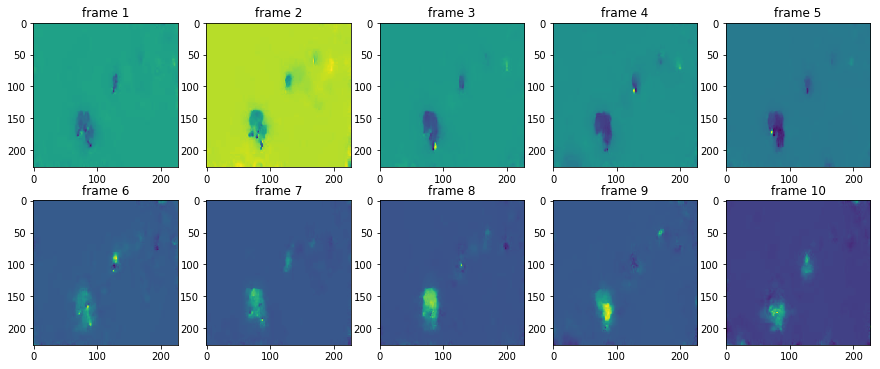

In [11]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(15,6))

for _, (d, l) in enumerate(data_loader):
    for i in range(10):
        a=fig.add_subplot(2,5,i+1)
        a.set_title('frame %d'%(i+1))
        plt.imshow(d[0][i])
    break
plt.show()

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(15,6))

for _, (d, l) in enumerate(data_loader):
    for i in range(10):
        a=fig.add_subplot(2,5,i+1)
        a.set_title('frame %d'%(i+1))
        plt.imshow(d[0][i])
    break
plt.show()

In [ ]:
model = CAE().to(device)
optimizer = torch.optim.Adagrad(model.parameters(), lr=learning_rate)
criteria = nn.MSELoss()

In [ ]:


for epoch in range(num_epochs):
    for i, (x, _) in enumerate(data_loader):
        x = x.to(device)
        x_reconst = model(x)
        
        reconst_loss = criteria(x_reconst, x)
    
        optimizer.zero_grad()
        reconst_loss.backward()
        optimizer.step()
        
        if(i+1)%10==0:
            print("Epoch[{}/{}], Step[{}/{}], Reconst Loss: {:.4f}"
                  .format(epoch+1, num_epochs, i+1, len(data_loader), reconst_loss.item()))
    with torch.no_grad():
        # Save the sampled images
        denorm = x[0]*0.5+0.5
        denorm_reconst = x_reconst[0]*0.5+0.5
        save_image(denorm.view(-1,1,227,227),os.path.join(sample_dir, 'sampled-{:03d}.png'.format(epoch+1)))
        
        # Save the reconstructed images
        x_concat = torch.cat([denorm.view(-1,1,227,227),denorm_reconst.view(-1,1,227,227)], dim = 3)
        save_image(x_concat, os.path.join(sample_dir, 'reconst-{:03d}.png'.format(epoch+1)))
        
        # Save the model parameters
        torch.save(model.state_dict(), (os.path.join(checkpoint_dir, 'checkpoint-{:03d}.pth'.format(epoch+1))))

In [ ]:
import matplotlib.pyplot as plt

losses = []
with open('loss.txt','r') as f:
    for line in f:
        losses.append(float(line.split(':')[1]))

plt.plot(losses)
plt.ylabel('Reconstruction Loss')
plt.xlabel('num_batches(x10)')
plt.show()


In [ ]:
from torch.utils.data.dataset import Dataset
import torch
class OpticalTestDataset(Dataset):
    def __init__(self, root, video_index, transforms=None):
        self.root=root
        self.video_index=video_index
        self.videos = os.listdir(self.root)
        self.videos.sort()
    def __getitem__(self, index):
        transform = transforms.Compose([
                                        transforms.Grayscale(),
                                        transforms.Resize([227,227]),
                                        transforms.ToTensor(),
                                        transforms.Normalize((0.5,),(0.5,))
                                        ])

        video_dir=os.path.join(self.root, self.videos[self.video_index])
        num_frame=len(os.listdir(video_dir))
        input_tensor = [torch.squeeze(transform(Image.open(os.path.join(video_dir, 'flow_x_%05d.jpg'%(i+1))))) for i in range(index, index+5)]+[torch.squeeze(transform(Image.open(os.path.join(video_dir, 'flow_y_%05d.jpg'%(i+1))))) for i in range(index, index+5)]
        input_tensor = torch.stack(input_tensor)
        return input_tensor
    
    def __len__(self):
        video_dir=os.path.join(self.root, self.videos[self.video_index])
        return int(len(os.listdir(video_dir))/3)-4

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CAE().to(device)
model.load_state_dict(torch.load('checkpoints/checkpoint-005.pth'))
test_dataset = OpticalTestDataset('test_data_opticalflow/',0)
criteria = nn.MSELoss()

In [ ]:
len(test_dataset)

In [ ]:
losses = []
for i in range(len(test_dataset)):
    with torch.no_grad():
        x = test_dataset[i]
        x = x.to(device)
        x.unsqueeze_(0)
        x_reconst = model(x)
        loss = criteria(x_reconst,x)
        losses.append(loss.item())
        print('loss: %f' % loss)

In [ ]:
max_loss = max(losses)
min_loss = min(losses)
regularity_list = [1 - (loss - min_loss) / max_loss for loss in losses]

In [ ]:
import matplotlib.pyplot as plt
print(regularity_list.index(min(regularity_list)))
plt.plot(regularity_list)
plt.show()
plt.imshow(Image.open('test_data/Avenue_testing_01/image-00947.jpg'))

In [ ]:
for i in range(0,69):
    test_dataset = OpticalTestDataset('test_data_opticalflow/',i)
    with open('testing_optical_regularity_list/'+'%d_reg.txt'%i, 'w') as f:
        losses = []
        for i in range(len(test_dataset)):
            with torch.no_grad():
                x = test_dataset[i]
                x = x.to(device)
                x.unsqueeze_(0)
                x_reconst = model(x)
                loss = criteria(x_reconst,x)
                losses.append(loss.item())
                print('loss: %f' % loss)
        max_loss = max(losses)
        min_loss = min(losses)
        regularity_list = [1 - (loss - min_loss) / max_loss for loss in losses]
        for j in range(len(regularity_list)):
            f.write('%f\n'%regularity_list[j])